# SolarKnowledge Model Training & Testing - PyTorch Implementation

This notebook provides an interface to train and test SolarKnowledge models for solar flare prediction using the PyTorch implementation that exactly matches the TensorFlow version's behavior for direct comparison.

## Setup & Import Dependencies

# Install required packages if not already installed
!pip install matplotlib seaborn tqdm scikit-learn

In [1]:
import sys
import os
import random
import numpy as np
import json
from datetime import datetime

# Ensure models directory is in the path
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if models_dir not in sys.path:
    sys.path.append(models_dir)

# Import necessary modules
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if PyTorch is using GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    print("Apple Silicon MPS available")
else:
    print("Using CPU")

PyTorch version: 2.7.0+cu126
CUDA available: True
CUDA device: NVIDIA A40


In [2]:
# Import required model functions
try:
    # Training modules
    from models.SolarKnowledge_run_all_trainings_pytorch import train as run_training, set_seed
    from models.SolarKnowledge_model_pytorch import SolarKnowledge
    from models.utils import supported_flare_class, get_training_data
    
    # Testing modules
    from models.SolarKnowledge_run_all_tests_pytorch import test_model, find_latest_model_version
    from models.utils import get_testing_data
    from sklearn.metrics import classification_report, confusion_matrix
    
    # Ensure consistent seed setting
    set_seed(RANDOM_SEED)
    
    print("Successfully imported all modules")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("\nPlease ensure the following files exist in the 'models' directory:")
    print("- SolarKnowledge_model_pytorch.py")
    print("- SolarKnowledge_run_all_trainings_pytorch.py")
    print("- SolarKnowledge_run_all_tests_pytorch.py")
    print("- utils.py")

CUDA available: enabling mixed precision training


2025-05-09 07:39:17.587672: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 07:39:21.063527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 07:39:21.063568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 07:39:21.281960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 07:39:21.438674: I tensorflow/core/platform/cpu_feature_guar

Python version: 3.11.12
Tensorflow bakcend version: 2.15.0

CUDA available: enabling mixed precision training
Python version: 3.11.12
Tensorflow bakcend version: 2.15.0

Successfully imported all modules

Training Configuration:
Flare Classes: C
Time Windows: 24
Version: Auto
Description: A6000-optimised config: deeper, wider, faster
Auto-increment: Yes

Hyperparameters:
Epochs: 200
Early Stopping Patience: 15
Learning Rate: 0.0003
Optimizer: AdamW
L1 Regularization: 1e-05
L2 Regularization: 0.0001
Scheduler: cosine_with_restarts (T_0=10, T_mult=2, min_lr=1e-06)
Embedding Dimension: 256
Transformer Blocks: 8
Batch Size: 2048
Using Focal Loss: Yes

Starting Training...
--------------------------------------------------

Training model for C-class flares with 24h window
Input shape: (10, 9)
Using Categorical Focal Loss for rare event awareness
Set regularization: L1=1e-05, L2=0.0001
[2025-05-09 07:40:22] Training is initiated for time window: 24 and flare class: C 
[2025-05-09 07:40:22] 

## Configure Training Parameters

Edit the parameters below to configure your training settings.

In [3]:
# Configuration parameters (modify these as needed)

# Basic parameters
flare_classes = ['C']  # Options: 'C', 'M', 'M5' - you can select multiple
time_windows = ['24']  # Options: '24', '48', '72' - you can select multiple
version = None  # Set to None for auto version or specify (e.g., '2')
description = "A6000-optimised config: deeper, wider, faster"  # Optional description of this training run
auto_increment = True  # Whether to auto-increment version numbers

# Model hyperparameters - A6000-optimised values
epochs = 200  # Give enough room for long convergence
patience = 15  # Allow extended early stopping
learning_rate = 3e-4  # Larger LR for faster convergence with larger batch
batch_size = 2048  # Exploit A6000's memory
embed_dim = 256  # Wider token embeddings
transformer_blocks = 8  # Deeper model
use_focal_loss = True  # Good for imbalanced datasets
compare_models = False  # Whether to compare models after training

# Optimizer and regularization
optimizer_type = 'AdamW'  # Switch to AdamW for decoupled weight decay
l1_regularization = 1e-5  # Match TensorFlow style
l2_regularization = 1e-4  # Match TensorFlow style

# Learning rate scheduler — use cosine annealing with restarts
scheduler_params = {
    "T_0": 10,        # First restart after 10 epochs
    "T_mult": 2,      # Double the period after each restart
    "eta_min": 1e-6   # Minimum LR
}
scheduler_type = "cosine_with_restarts"

# Display current settings
print("\nTraining Configuration:")
print(f"Flare Classes: {', '.join(flare_classes)}")
print(f"Time Windows: {', '.join(time_windows)}")
print(f"Version: {'Auto' if version is None else version}")
print(f"Description: {'None' if description is None else description}")
print(f"Auto-increment: {'Yes' if auto_increment else 'No'}")

print("\nHyperparameters:")
print(f"Epochs: {epochs}")
print(f"Early Stopping Patience: {patience}")
print(f"Learning Rate: {learning_rate}")
print(f"Optimizer: {optimizer_type}")
print(f"L1 Regularization: {l1_regularization}")
print(f"L2 Regularization: {l2_regularization}")
print(f"Scheduler: {scheduler_type} (T_0={scheduler_params['T_0']}, T_mult={scheduler_params['T_mult']}, min_lr={scheduler_params['eta_min']})")
print(f"Embedding Dimension: {embed_dim}")
print(f"Transformer Blocks: {transformer_blocks}")
print(f"Batch Size: {batch_size}")
print(f"Using Focal Loss: {'Yes' if use_focal_loss else 'No'}")

## Run Training

Execute the training with the configured parameters. You can monitor progress with epoch-by-epoch metrics.

In [10]:
# Store trained models information
trained_models = []
versions = []

# Validate selections
if not flare_classes:
    print("Error: Please select at least one flare class")
else:
    if not time_windows:
        print("Error: Please select at least one time window")
    else:
        print("\nStarting Training...")
        print("-"*50)
        
        # Run training for each combination
        for time_window in time_windows:
            for flare_class in flare_classes:
                if flare_class not in supported_flare_class:
                    print(f"Unsupported flare class: {flare_class}")
                    continue
                    
                print(f"\nTraining model for {flare_class}-class flares with {time_window}h window")
                
                try:
                    # First, get the input shape from the training data
                    X_train, _ = get_training_data(time_window, flare_class)
                    input_shape = (X_train.shape[1], X_train.shape[2])
                    print(f"Input shape: {input_shape}")
                    
                    # Create a customized model instance with our parameters
                    model = SolarKnowledge(early_stopping_patience=patience)
                    
                    # Build the model
                    model.build_base_model(
                        input_shape=input_shape,
                        embed_dim=embed_dim,
                        num_heads=8,
                        ff_dim=1024,
                        num_transformer_blocks=transformer_blocks,
                        dropout_rate=0.3
                    )
                    
                    # Compile the model
                    model.compile(
                        use_focal_loss=use_focal_loss,
                        learning_rate=learning_rate,
                        weight_decay=1e-4
                    )
                    
                    # Model.model is the actual PyTorch model
                    if hasattr(model.model, 'l1_regularizer') and hasattr(model.model, 'l2_regularizer'):
                        # Set regularization strengths to match TensorFlow
                        model.model.l1_regularizer = l1_regularization
                        model.model.l2_regularizer = l2_regularization
                        print(f"Set regularization: L1={l1_regularization}, L2={l2_regularization}")
                    
                    # Set up custom hyperparameters dictionary for model_tracking
                    hyperparams = {
                        "learning_rate": learning_rate,
                        "weight_decay": 1e-4,
                        "batch_size": batch_size,
                        "early_stopping_patience": patience,
                        "early_stopping_metric": "loss",
                        "epochs": epochs,
                        "num_transformer_blocks": transformer_blocks,
                        "embed_dim": embed_dim,
                        "num_heads": 8,
                        "ff_dim": 1024,
                        "dropout_rate": 0.3,
                        "focal_loss": use_focal_loss,
                        "focal_loss_alpha": 0.25,
                        "focal_loss_gamma": 2.0,
                        "framework": "pytorch",
                        "gradient_clipping": True,
                        "max_grad_norm": 1.0,
                        "input_shape": input_shape,
                        "lr_scheduler": {
                            "type": "cosine_with_restarts",
                            "T_0": scheduler_params["T_0"],
                            "T_mult": scheduler_params["T_mult"],
                            "eta_min": scheduler_params["eta_min"]
                        },
                        "regularization": {
                            "l1": l1_regularization,
                            "l2": l2_regularization
                        },
                        "optimizer": optimizer_type,
                        "random_seed": RANDOM_SEED
                    }
                    
                    # Run the training function
                    model_dir, trained_version = run_training(
                        time_window,
                        flare_class,
                        version=version,
                        description=description,
                        auto_increment=auto_increment,
                        custom_model=model,
                        custom_hyperparams=hyperparams,
                        epochs=epochs,
                        batch_size=batch_size,
                        learning_rate=learning_rate,
                        embed_dim=embed_dim,
                        transformer_blocks=transformer_blocks,
                        use_focal_loss=use_focal_loss
                    )
                    
                    trained_models.append({
                        "time_window": time_window,
                        "flare_class": flare_class,
                        "model_dir": model_dir,
                        "version": trained_version
                    })
                    versions.append(trained_version)
                    
                    print(f"\nModel saved to {model_dir}")
                    print("-"*50)
                    
                except Exception as e:
                    print(f"Error training model: {e}")
                    import traceback
                    traceback.print_exc()

Training:  86%|████████▌ | 18/21 [00:02<00:00,  8.89it/s, accuracy=0.971, loss=0.17, tss=0.819] 


KeyboardInterrupt: 

## Configure Testing Parameters

Edit the parameters below to configure your testing settings.

In [5]:
# Testing configuration
test_flare_classes = flare_classes  # Default to same as training
test_time_windows = time_windows    # Default to same as training
mc_passes = 30                      # Number of Monte Carlo dropout passes for uncertainty estimation
plot_uncertainties = True           # Whether to generate uncertainty visualization plots
test_latest = True                  # Test the latest model versions by default
test_specific_version = None        # Set to a specific version string to test it instead

# Display testing settings
print("\nTesting Configuration:")
print(f"Flare Classes: {', '.join(test_flare_classes)}")
print(f"Time Windows: {', '.join(test_time_windows)}")
print(f"Monte Carlo Passes: {mc_passes}")
print(f"Generate Uncertainty Plots: {'Yes' if plot_uncertainties else 'No'}")
print(f"Test Latest Models: {'Yes' if test_latest else 'No'}")
print(f"Test Specific Version: {test_specific_version if test_specific_version else 'No'}")

## Run Testing

Execute testing on the trained models with the configured parameters. This will provide detailed performance metrics and uncertainty visualizations.

In [6]:
# Dictionary to store all test results
all_test_results = {}

# Run tests for each model
for time_window in test_time_windows:
    if time_window not in all_test_results:
        all_test_results[time_window] = {}
        
    for flare_class in test_flare_classes:
        if flare_class not in supported_flare_class:
            print(f"Unsupported flare class: {flare_class}")
            continue
            
        print(f"\nTesting model for {flare_class}-class flares with {time_window}h window")
        print("-"*50)
        
        try:
            # Find the model directory to test
            model_dir = None
            
            if test_specific_version:
                # Look for a specific version
                model_patterns = [
                    # New structure: models/models/SolarKnowledge-v*
                    os.path.join("models", "models", f"SolarKnowledge-v{test_specific_version}-{flare_class}-{time_window}h"),
                    # Old structure: models/SolarKnowledge-v*
                    os.path.join("models", f"SolarKnowledge-v{test_specific_version}-{flare_class}-{time_window}h"),
                ]
                
                for pattern in model_patterns:
                    if os.path.exists(pattern):
                        model_dir = pattern
                        break
                        
                if not model_dir:
                    print(f"Could not find model with version {test_specific_version}")
                    continue
                    
            else:
                # Find the latest model version
                model_dir = find_latest_model_version(flare_class, time_window)
                
                if not model_dir:
                    print(f"Could not find a model for {flare_class}-class flares with {time_window}h window")
                    continue
            
            print(f"Testing model at: {model_dir}")
            
            # Run the test
            test_results = test_model(
                time_window,
                flare_class,
                use_latest=True,
                mc_passes=mc_passes,
                plot_uncertainties=plot_uncertainties
            )
            
            # Store results
            if test_results is not None:
                all_test_results[time_window][flare_class] = test_results
                
                # Print a summary of the results
                print("\nTest Results Summary:")
                print(f"Accuracy: {test_results['accuracy']}")
                print(f"TSS: {test_results['TSS']}")
                print(f"Precision: {test_results['precision']}")
                print(f"Recall: {test_results['recall']}")
                print(f"Balanced Accuracy: {test_results['balanced_accuracy']}")
                
                # Show uncertainty information if available
                if 'mean_uncertainty' in test_results:
                    print(f"\nUncertainty Metrics:")
                    print(f"Mean Uncertainty: {test_results['mean_uncertainty']:.4f}")
                    print(f"Mean Confidence: {test_results['mean_confidence']:.4f}")
                    print(f"Mean Entropy: {test_results['mean_entropy']:.4f}")
                
                # Print confusion matrix if available
                if 'confusion_matrix' in test_results:
                    print("\nConfusion Matrix:")
                    cm = test_results['confusion_matrix']
                    print(f"[[{cm[0][0]}, {cm[0][1]}]")
                    print(f" [{cm[1][0]}, {cm[1][1]}]]")
                    
                    # Calculate and print additional metrics
                    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
                    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    print(f"Sensitivity (TPR): {sensitivity:.4f}")
                    print(f"Specificity (TNR): {specificity:.4f}")
                    print(f"False Positive Rate: {1-specificity:.4f}")
                    print(f"False Negative Rate: {1-sensitivity:.4f}")
                
                # Show sample distribution
                if all(k in test_results for k in ["test_samples", "positive_samples", "negative_samples"]):
                    print(f"\nTest Data Distribution:")
                    pos = test_results["positive_samples"]
                    neg = test_results["negative_samples"]
                    total = test_results["test_samples"]
                    print(f"Total samples: {total}")
                    print(f"Positive samples: {pos} ({pos/total:.2%})")
                    print(f"Negative samples: {neg} ({neg/total:.2%})")
            else:
                print("No test results returned.")
                
        except Exception as e:
            print(f"Error testing model: {e}")
            import traceback
            traceback.print_exc()
            
        print("-"*50)
        
# Save all test results to a JSON file
results_filename = f"pytorch_test_results_{datetime.now().strftime('%Y%m%d%H%M%S')}.json"
with open(results_filename, "w") as f:
    json.dump(all_test_results, f, indent=4)
    
print(f"\nAll test results saved to {results_filename}")

## Visualize Test Results

Create visualizations to better understand model performance.

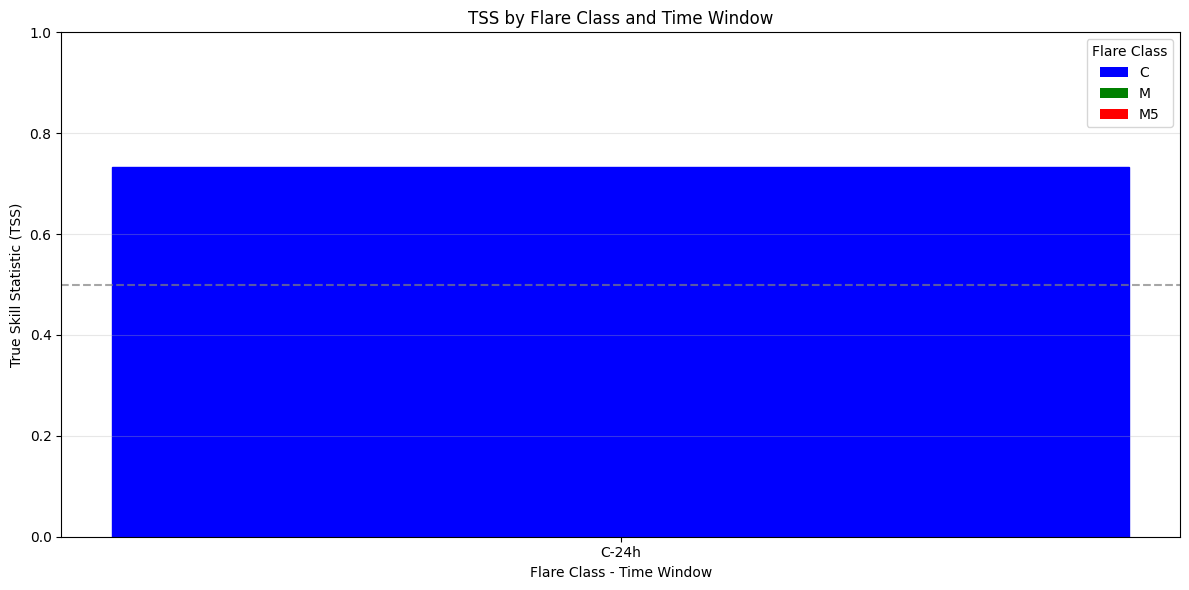

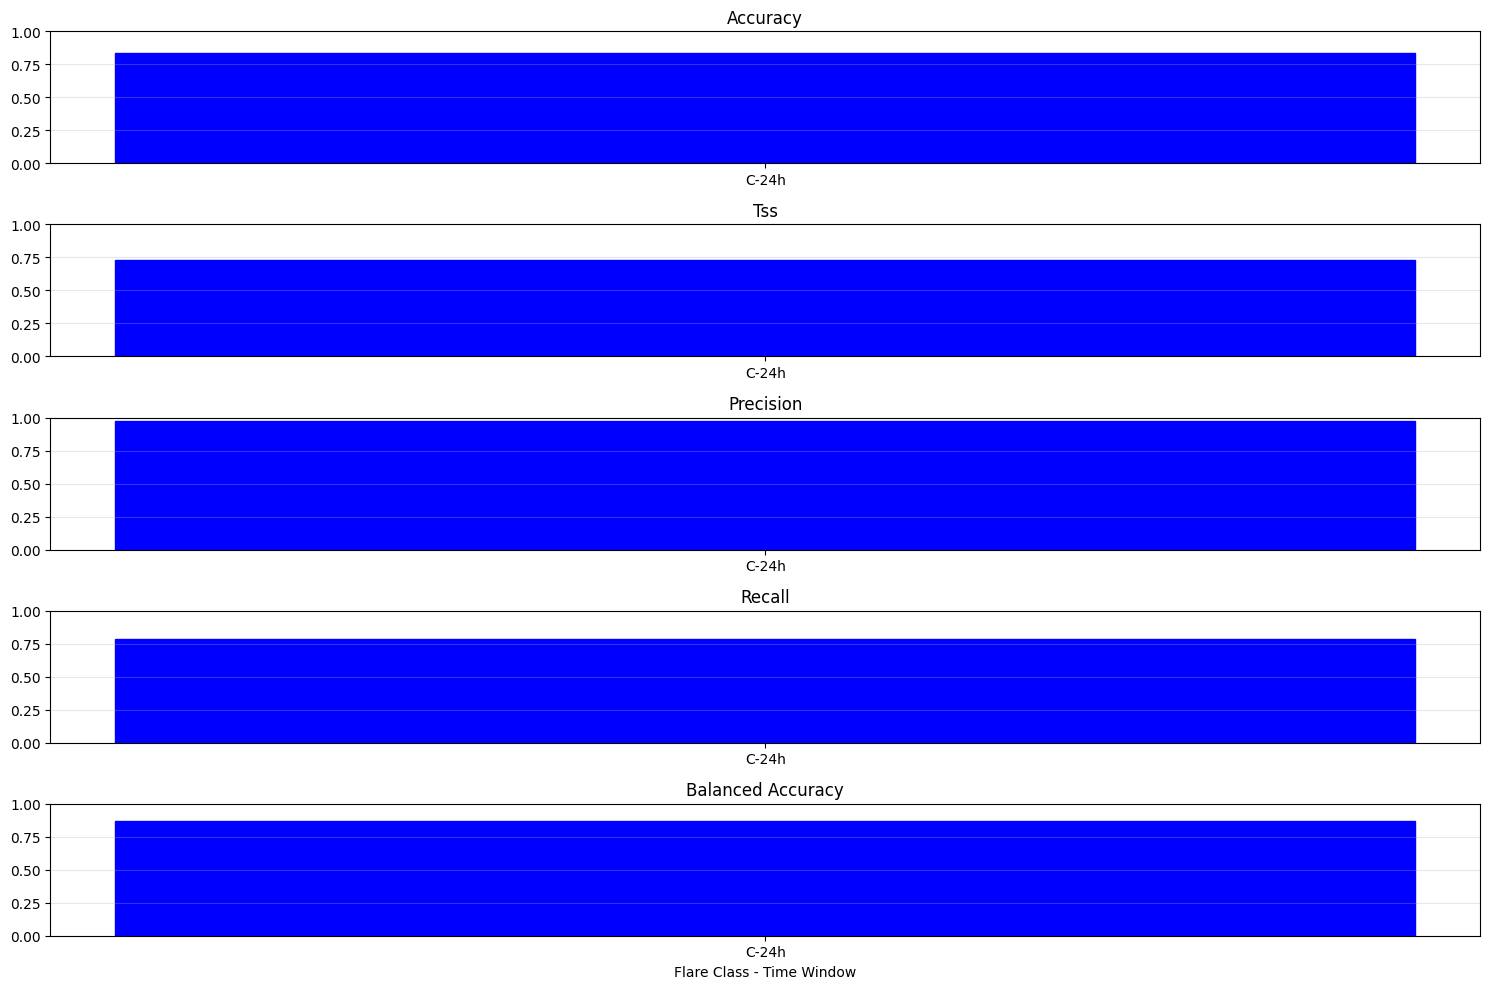

In [7]:
# Visualize TSS values across different flare classes and time windows
if all_test_results:
    plt.figure(figsize=(12, 6))
    
    # Extract TSS values
    x_labels = []
    tss_values = []
    colors = {'C': 'blue', 'M': 'green', 'M5': 'red'}
    
    for tw in sorted(all_test_results.keys()):
        for fc in sorted(all_test_results[tw].keys()):
            if 'TSS' in all_test_results[tw][fc]:
                x_labels.append(f"{fc}-{tw}h")
                tss_values.append(all_test_results[tw][fc]['TSS'])
    
    # Create bar chart
    bars = plt.bar(x_labels, tss_values)
    
    # Color bars based on flare class
    for i, label in enumerate(x_labels):
        fc = label.split('-')[0]
        if fc in colors:
            bars[i].set_color(colors[fc])
    
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.title('TSS by Flare Class and Time Window')
    plt.xlabel('Flare Class - Time Window')
    plt.ylabel('True Skill Statistic (TSS)')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=fc) for fc, color in colors.items()]
    plt.legend(handles=legend_elements, title='Flare Class')
    
    plt.tight_layout()
    plt.show()
    
    # Create a comparison of key metrics
    metrics = ['accuracy', 'TSS', 'precision', 'recall', 'balanced_accuracy']
    plt.figure(figsize=(15, 10))
    
    # Plot different metrics side by side for each model
    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics), 1, i+1)
        
        x_labels = []
        values = []
        
        for tw in sorted(all_test_results.keys()):
            for fc in sorted(all_test_results[tw].keys()):
                if metric in all_test_results[tw][fc]:
                    x_labels.append(f"{fc}-{tw}h")
                    values.append(all_test_results[tw][fc][metric])
        
        # Create bar chart
        bars = plt.bar(x_labels, values)
        
        # Color bars based on flare class
        for j, label in enumerate(x_labels):
            fc = label.split('-')[0]
            if fc in colors:
                bars[j].set_color(colors[fc])
        
        plt.title(f'{metric.replace("_", " ").title()}')
        plt.ylim(0, 1.0)
        plt.grid(axis='y', alpha=0.3)
        
        # Only show x-labels for the bottom subplot
        if i == len(metrics)-1:
            plt.xlabel('Flare Class - Time Window')
    
    plt.tight_layout()
    plt.show()
else:
    print("No test results available for visualization")

## Compare Results with TensorFlow Implementation

If you have saved TensorFlow model results, you can load and compare them with the PyTorch implementation.

In [8]:
# Check if TensorFlow results exist and compare
tf_results_file = "tensorflow_results.json"  # Change this to your TensorFlow results file name

if os.path.exists(tf_results_file):
    try:
        # Load TensorFlow results
        with open(tf_results_file, 'r') as f:
            tf_results = json.load(f)
        
        # Prepare for comparison
        comparison_metrics = ['TSS', 'accuracy', 'precision', 'recall']
        frameworks = ['TensorFlow', 'PyTorch']
        
        # For each time window and flare class, collect and compare metrics
        for tw in sorted(all_test_results.keys()):
            if tw in tf_results:
                print(f"\nComparison for {tw}h Time Window:")
                print("-"*50)
                
                # Print header row
                header = "Flare Class | Metric | " + " | ".join(frameworks)
                print(header)
                print("-" * len(header))
                
                for fc in sorted(all_test_results[tw].keys()):
                    if fc in tf_results[tw]:
                        for metric in comparison_metrics:
                            if metric in tf_results[tw][fc] and metric in all_test_results[tw][fc]:
                                # Format values for printing
                                tf_val = tf_results[tw][fc][metric]
                                pt_val = all_test_results[tw][fc][metric]
                                
                                # Calculate difference
                                if isinstance(tf_val, (int, float)) and isinstance(pt_val, (int, float)):
                                    diff = pt_val - tf_val
                                    diff_str = f"{diff:+.4f}"
                                else:
                                    diff_str = "N/A"
                                
                                # Print comparison row
                                print(f"{fc:^10} | {metric:^12} | {tf_val:^10} | {pt_val:^10} | {diff_str:^10}")
                        
                        # Add a separator between flare classes
                        print("-" * len(header))
    except Exception as e:
        print(f"Error comparing results: {e}")
else:
    print(f"TensorFlow results file '{tf_results_file}' not found. Skipping comparison.")

## Compare Models (Optional)

Run this cell if you want to compare different model versions after training

In [9]:
# Compare models if requested and if models were trained
if compare_models and trained_models:
    print("\nComparing trained models...")
    try:
        from models.model_tracking import compare_models as compare_models_function
        comparison = compare_models_function(
            list(set(versions)),  # Unique versions
            flare_classes,
            time_windows
        )
        print("\nModel Comparison:")
        print(comparison)
    except Exception as e:
        print(f"Error comparing models: {e}")
else:
    if not compare_models:
        print("Model comparison skipped (set compare_models = True to enable)")
    elif not trained_models:
        print("No models were trained to compare")